## Imports necessary libraries and custom modules

In [4]:
# Import necessary libraries
import sys
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from inpoly_cython import inpoly2
import numpy as np

# Add source directory to path
sys.path.append('src/')

# Import custom modules
import visilibity
from SPM import SPM # Handles shortest path distance calculations
from EDR import EDR # Fits elevation-distance relationships
import gis_utils # Provides geospatial utility functions
import fanTopo # Generates fan topography based on input parameters (Initial topography, elevation-distance relationship, apex location)
import plt_utils # Contains plotting utilities

### Setup the file paths
- File paths for pre-event and later post-event DEM, as well as shapefiles for boundary $\mathcal{B}$ and removal areas, are defined.

In [5]:
# Define file paths
topo_pre_event = r"datasets\raw\tif\Yushui\YuShui_2017_2022_minimum_10m.tif"
topo_post_event = r"datasets\raw\tif\Yushui\YuShui_2022_10m.tif"
shape_fan_boundary = r"datasets\raw\shape\boundary_fan\Yushui_inverse_boundary.shp"
shape_remove_area = r"datasets\raw\shape\boundary_remove\remove.shp"

# Inverse method

## Generating the Shortest Path Map (SPM) Based on $\mathcal{B}$

- The `SPM` class is created to calculate shortest path distances.
- **Inputs**:
    - `topo_tiffile`: The mesh size of the SPM will match the resolution of the provided topographic file. The apex point is selected as the maximum elevation point within the fan boundary $\mathcal{B}$, if `xyApex` is not defined.
    - `fan_boundary_shapefile`: The shapefile representing the fan boundary $\mathcal{B}$.
    - `xyApex`: The manually defined apex location.

In [6]:
# Create shortest path distance object
shortest_path_distance = SPM(topo_post_event, shape_fan_boundary)

### Calculate the shortest path map within boundary

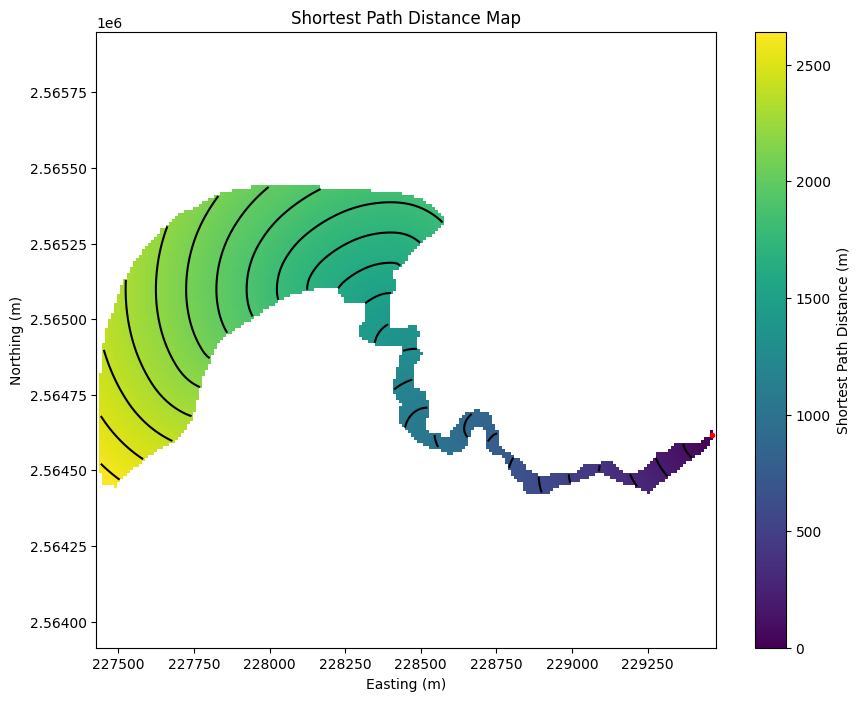

In [7]:
# Get coordinates within boundary
xMesh_crop, yMesh_crop, zMesh_crop, sMesh_crop = shortest_path_distance.within_boundary(pltFlag=True)

### Calculate the shortest path map along boundary

Processing shortest paths: 100%|██████████| 724/724 [01:42<00:00,  7.03it/s]


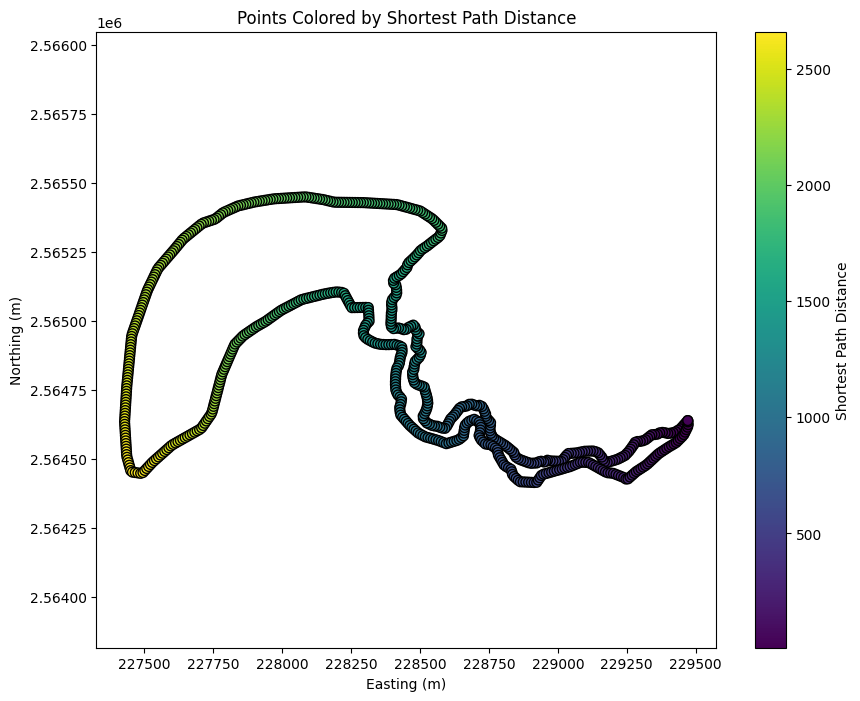

In [8]:
# Get coordinates along boundary
boundary_x, boundary_y, boundary_z, boundary_s = shortest_path_distance.along_boundary(pltFlag=True)

### Excluded the area modified by excavation work from inverse analysis

<Figure size 500x400 with 0 Axes>

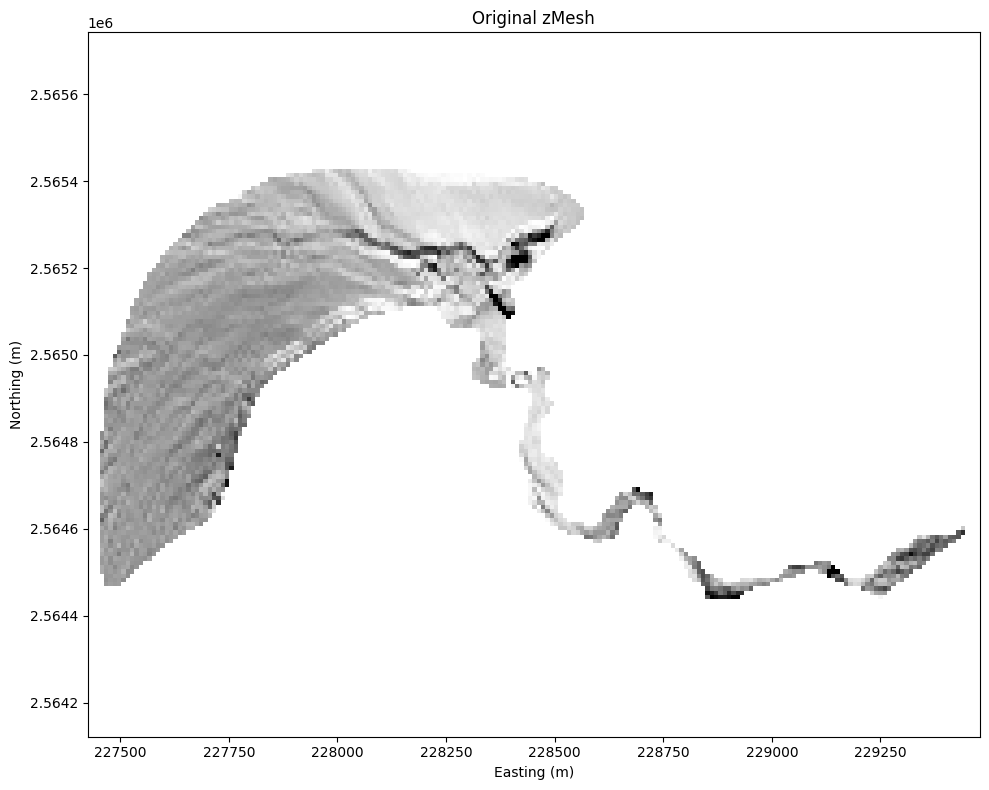

<Figure size 500x400 with 0 Axes>

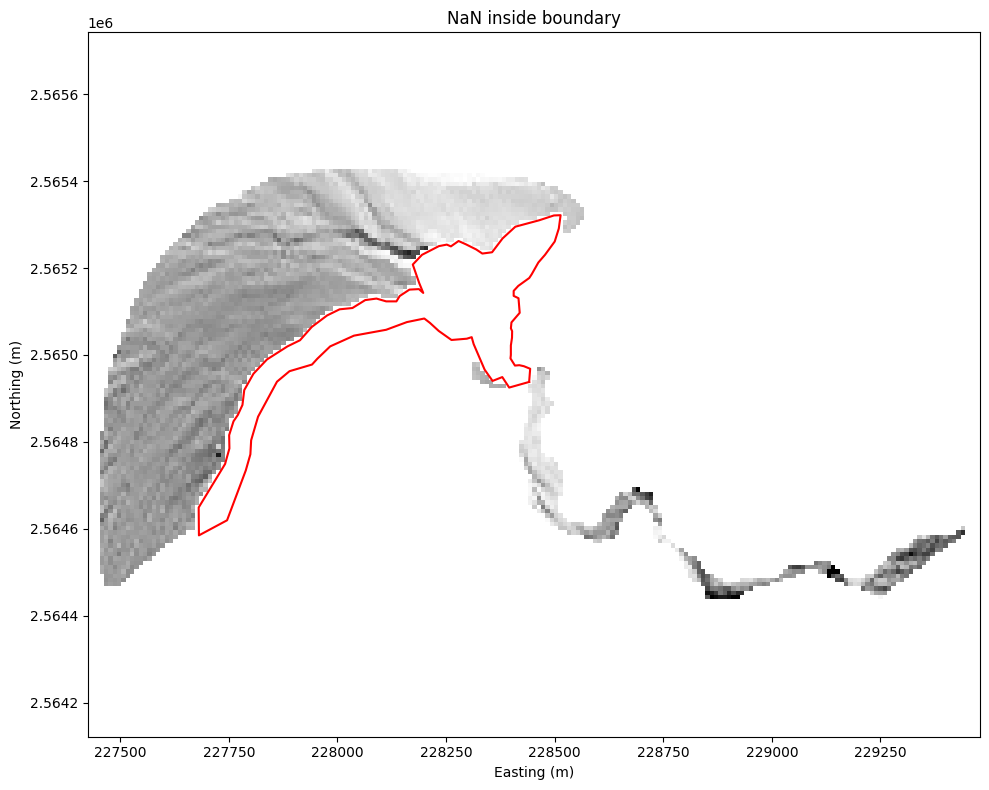

In [9]:
remove_boundary_x, remove_boundary_y = gis_utils.read_shapefile_boundary(shape_remove_area)

# Create boundary polygon from the boundary coordinates
boundary_nodes = np.column_stack((remove_boundary_x[0], remove_boundary_y[0]))

# If the boundary points are not already forming a closed polygon,
# add the first point at the end to close it
if not np.array_equal(boundary_nodes[0], boundary_nodes[-1]):
    boundary_nodes = np.vstack((boundary_nodes, boundary_nodes[0]))

# Create edge connections
num_nodes = len(boundary_nodes)
edge = np.column_stack((np.arange(num_nodes-1), np.arange(1, num_nodes)))

# Reshape to 1D arrays for the inpoly2 function
mesh_points = np.column_stack((xMesh_crop.flatten(), yMesh_crop.flatten()))

# Call inpoly2 to find points inside the boundary
inside, _ = inpoly2(mesh_points, boundary_nodes, edge)

# Reshape the result to match your mesh shape
inside_mask = inside.reshape(xMesh_crop.shape)

# Set values inside the boundary to NaN
zMesh_crop_masked = zMesh_crop.copy()

zMesh_crop_masked[inside_mask] = np.nan

plt.figure(figsize=(5, 4))
plt_utils.plot_hillshade(xMesh_crop, yMesh_crop, zMesh_crop, azdeg=180, altdeg=45, vert_exag=5)
plt.title('Original zMesh')
plt.axis('equal')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5, 4))
plt_utils.plot_hillshade(xMesh_crop, yMesh_crop, zMesh_crop_masked, azdeg=180, altdeg=45, vert_exag=5)
plt.plot(remove_boundary_x[0], remove_boundary_y[0], 'r-')
plt.title('NaN inside boundary')
plt.axis('equal')
plt.tight_layout()
plt.show()

## Fitting a quadratic function to the elevation-distance relationship
- The `EDR` class is created to retrive elevation-distance relationship.
- **Inputs**:
    - `sMap`: The shortest path map or shortest path distance along boundary calculated in the previous step.
    - `zMap`: The elevation values corresponding to the shortest path map.
    - `xyApex`: The manually defined apex location.
- **Methods**:
    - `medianFilter_on`: Applies median filtering to the elevation data, performs polynomial fitting, and optionally visualizes the results.
    - `medianFilter_off`: Performs polynomial fitting on the raw elevation data without median filtering, and optionally visualizes the results.

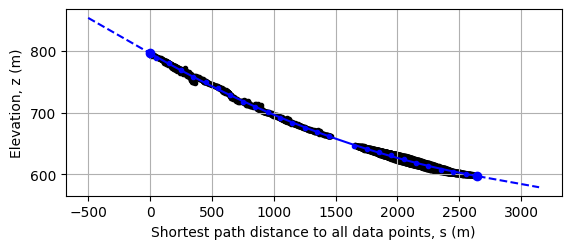

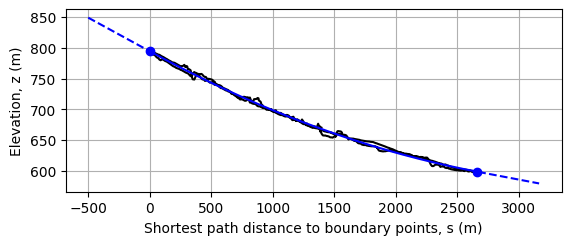

In [17]:
# Parameters setting of median filter and quadratic elevation-distance relationship
bin_size = 100
ds = 5
outlength = 500

# Apply filters to the data
fitting_s_z_within_boundary = EDR(sMesh_crop, zMesh_crop_masked).medianFilter_on(bin_size, ds, outlength, pltFlag='results/elevation_distance_relationship.png')
fitting_s_z_along_boundary = EDR(boundary_s, boundary_z).medianFilter_off(ds, outlength, pltFlag=True)

## Morphometric fan analysis

In [12]:
fitting_s_z_within_boundary, slope, dimensionless_drop, RMSE_value, L, S, P, s_T, bin_pts_mid_s, Q2 = EDR(sMesh_crop, zMesh_crop_masked).medianFilter_on(bin_size, ds, outlength, pltFlag=False, return_fitting_coeff=True)

print("Morphometric Parameters for the fan using (s,z) dataset within boundary:")
print("Mean fan slope:", slope)
print("Dimensionless Drop:", dimensionless_drop)
print("RMSE Value:", RMSE_value)
print("L:", L)
print("S:", S)
print("P:", P)
print("s_T:", s_T)

fitting_s_z_along_boundary, slope, dimensionless_drop, RMSE_value, L, S, P, s_T = EDR(boundary_s, boundary_z).medianFilter_off(ds, outlength, pltFlag=False, return_fitting_coeff=True)

print("\n")
print("Morphometric Parameters for the fan using (s,z) dataset along boundary:")
print("Mean fan slope:", slope)
print("Dimensionless Drop:", dimensionless_drop)
print("RMSE Value:", RMSE_value)
print("L:", L)
print("S:", S)
print("P:", P)
print("s_T:", s_T)

Morphometric Parameters for the fan using (s,z) dataset within boundary:
Mean fan slope: 0.07515189009066567
Dimensionless Drop: 0.00977412985601354
RMSE Value: 2.4653488158158345
L: 1.4800559113737085e-05
S: -0.11424840951471983
P: 796.0300071330123
s_T: 2641.556925222296


Morphometric Parameters for the fan using (s,z) dataset along boundary:
Mean fan slope: 0.07358059687993976
Dimensionless Drop: 0.008907807923230324
RMSE Value: 3.0378107369498735
L: 1.3394845900885297e-05
S: -0.10921182857286105
P: 794.4860924212275
s_T: 2660.0702954385124


# Forward method

## Fan surface reconstruction
- Reconstructs the fan surface using the fitted quadratic elevation-distance profile from the inverse method.

In [13]:
# Read the pre-event DEM
xMesh, yMesh, zMesh = gis_utils.read_geotiff(topo_pre_event)

# Get apex coordinates
xApex, yApex = shortest_path_distance.xyApex()

# Get the elevation of the apex
interp1d_func = interp1d(fitting_s_z_within_boundary[:, 0], fitting_s_z_within_boundary[:, 1], fill_value="extrapolate")
zApex = interp1d_func(0)

zTopo= fanTopo.fan_topo(xMesh, yMesh, zMesh, [xApex], [yApex], [zApex], {
            'caseName': 'myProfile',
            'sz_interpM': [fitting_s_z_within_boundary],
            })

### Plotting the fan surface

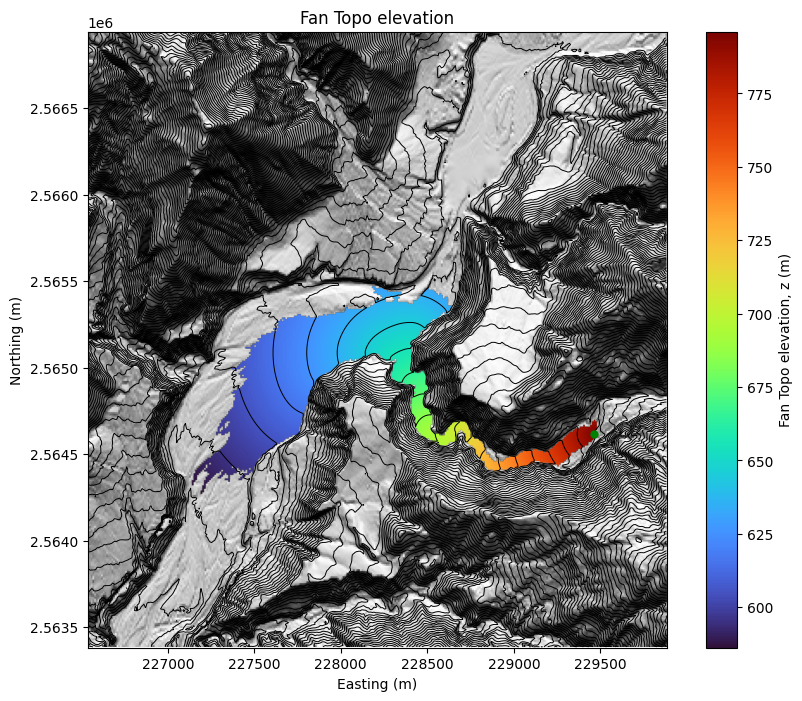

In [16]:
zTopoMesh = zTopo[0]
nanIndexMesh = np.isnan(zTopo[0])
zMapMesh = zTopoMesh.copy()
zMapMesh[nanIndexMesh] = zMesh[nanIndexMesh]
plt_utils.plot_hillshade(xMesh, yMesh, zMapMesh, azdeg=180, altdeg=45, vert_exag=5)
dxMesh = xMesh[0,1] - xMesh[0,0]
dyMesh = yMesh[0,0] - yMesh[1,0]
plt.imshow(zTopoMesh, extent=(xMesh.min()-dxMesh/2, xMesh.max()+dxMesh/2, yMesh.min()-dyMesh/2, yMesh.max()+dyMesh/2), origin='upper', cmap='turbo')
plt.colorbar(label = 'Fan Topo elevation, z (m)')
counter_interval = 10
levels = np.arange(zMapMesh.min(), zMapMesh.max(), counter_interval)
plt.contour(xMesh, yMesh, zMapMesh, levels=levels, colors='k', linewidths=0.7)
plt.plot(xApex, yApex, 'go', markersize=5)
plt.title('Fan Topo elevation')
plt.savefig('results/fan_topo.png', dpi=300, bbox_inches='tight')

### Exporting the reconstructed fan surface to a GeoTIFF file

In [ ]:
# Get EPSG code and write results to GeoTIFF
epgs_code = gis_utils.get_epsg_code(topo_pre_event)
gis_utils.write_geotiff('results/Yushui_2021_reconstruction.tif', xMesh, yMesh, zTopo[0], epgs_code)
